<font face = "Calibri"><font size = 4>
## **AirBNB Rio de Janeiro Data**  

Some facts:

- "Airbnb, Inc. is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities." _Wikipedia_  
- 2020 and 2021 were terrible years to travel and maybe it could a difficult moment for who rent by site. However, it seems that 2022 things will return to certain level of normality  
- One of most desired city to travel is Rio de Janeiro. Beatiful city, owned a lot of natural beaties and full of receptive people.   

The company provide for public some pieces of it data.
In this notebook, data from Rio de Janeiro city were downloaded from this link: http://insideairbnb.com/get-the-data.html  

Specifically, these were the three datasets for this work:  

- listling id: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/listings.csv.gz  
- calendar: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/calendar.csv.gz  
- reviews: http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2021-09-28/data/reviews.csv.gz  

The objective here it is to analyze the datasets and explore three subjects:  
1. For future months, will there <b>any tendency for booking</b>?  
2. Both Brazilians and foreigns love to travel to Rio. But <b>has Brazillians different neighborhood preference</b> for stay?
3. Price is a key factor in bookings. <b>But what matters for the price value?</b> What features of accomodations most impact?  



<font face="Calibri"><font size= 4>
### **Libaries and loading datasets**

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

# Setting a good theme for seaborn
sns.set_theme(style="darkgrid")

# Reading datasets
list_df = pd.read_csv('../database/listings.csv')
calendar_df = pd.read_csv('./database/calendar.csv')
review_df = pd.read_csv('./database/reviews.csv')
# review_df = pd.read_csv('./database/reviews_with_lang.csv', usecols=[1,2,3,4,5,6,7])

<font face="Calibri"><font size= 4>
# 1. For future months, will there <b>any tendency for booking</b>?  

The main dataset to work with is the calendar_df.  
Data in this dataset is a list of accommodations and the booking for the next one year.  
  
The main ideia here was to create a dataframe of demand.  
To analyze the occupation rate, it was considered 'f' value for avaible column


In [18]:
# Just necessary columns and new name
demand_df = calendar_df[['listing_id', 'date', 'available']]

# Create a list of month and create a column in dataframe, 
# so that it will be possible analyze by month
months = pd.date_range(start=demand_df.date.min(), end=demand_df.date.max(), periods=13, normalize=True).strftime('%b %y') # To be used after
demand_df['month_year'] = pd.DatetimeIndex(demand_df.date).strftime('%b %y')

# Rule: if the id is available, so it is not occupied
demand_df['occupied'] = demand_df.available.map({'f':1, 't':0})

# Group data by month, taking the avarage of day occupied
# The mean of 1 (ones, occupied) represent the rate of 
# occupied days in month
occupied_df = demand_df.groupby(by=['month_year']).mean()[['occupied']]

# Sep 21 has only three days, so its mean is greater than others. So, take it off
occupied_df = occupied_df.drop('Sep 21')


<font face="Calibri"><font size= 5>
Ok, with occupied_df ready, it's time to plot some bars and see if there's a tendency

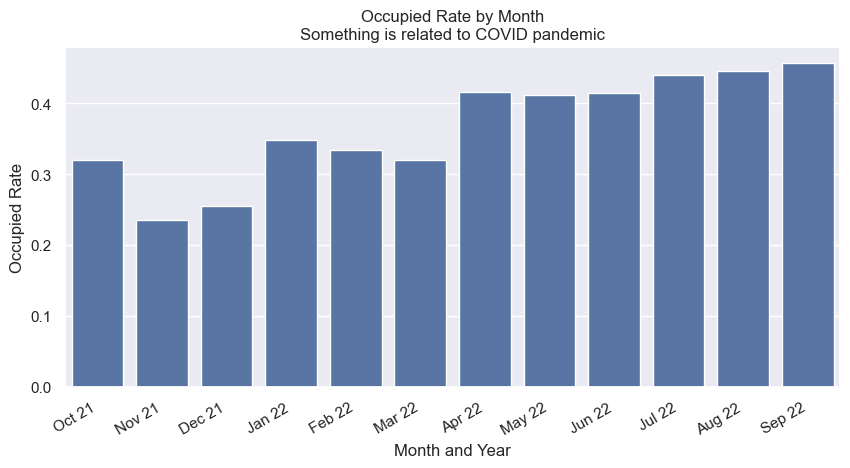

In [19]:
# Plotting the occupied rate by month
sns.barplot(x=occupied_df.index, y=occupied_df.occupied, order=months[1:], color='b')
f, ax = plt.gcf(), plt.gca()
f.set(dpi=100, size_inches=(10,5)); f.autofmt_xdate()
ax.set(xlabel='Month and Year', ylabel='Occupied Rate', title='Occupied Rate by Month\nSomething is related to COVID pandemic')
plt.show()

<font face="Calibri"><font size= 5>

It's seems that the occupied rate is big next year.  
This could represent the returning of tourism activity after COVID pandemic.  
People are confident about next year, so we see almost 45% of ocupation in Rio.  

Important to note that rate raises in January and fall until March. In spite of Carnaval in March, January atract more tourists because it's summer time in the city.

<font face="Calibri"><font size= 5>

In Rio, there are a lot of famous neighborhood, as Copacabana and Ipanema.  
After seen this first look of demand, the question appears: maybe some of neighborhood could have different demand?

In [ ]:
# Creating a dataframe with neighborhodd of each listing id
neighborhood_list_df = list_df[['id','neighbourhood_cleansed']].\
                             rename({'neighbourhood_cleansed':'neigh'}, axis=1)

# Merge two dataframes
demand_w_neigh_df = demand_df.merge(neighborhood_list_df, left_on='listing_id', right_on='id')

# Group dataframe by month and neighborhood. 
# Taking average of occupied days
occupied_w_neigh_df = demand_w_neigh_df.groupby(['month_year','neigh']).mean()[['occupied']]

# By having a lot of neighborhood, it's better filter the
# top five neighborhood in number of listings
top_5_neigh = demand_w_neigh_df.groupby(['neigh']).agg({'id':lambda x: x.nunique()}).\
                                sort_values('id')[-5:].index.to_list()
demand_w_neigh_df = demand_w_neigh_df[demand_w_neigh_df.neigh.isin(top_5_neigh)]

# Creating a auxiliar dataframe to analyse the occupation in top 
df_aux = demand_w_neigh_df.groupby(['month_year','neigh']).\
                           agg({'occupied':'mean','id':lambda x: x.nunique()}). \
                           assign(occu_ind=lambda x: x['occupied']*x['id']).\
                           sort_values('occu_ind').\
                           reset_index()

# Again, ignore september 2021
df_aux = df_aux[df_aux['month_year'] != 'Sep 21']

# Plotting the occupation rate by neighborhodd
g = sns.FacetGrid(data=df_aux, col="neigh")
g.map_dataframe(sns.barplot, x='month_year', y='occupied', order=months[1:], color='b' )
f, ax = plt.gcf(), plt.gca()
f.set(dpi=100, size_inches=(20,5)); f.autofmt_xdate()
# ax.set(xlabel='Month and Year', ylabel='Occupied Rate', title='Occupied Rate by Month\nSomething is related to COVID pandemic')
plt.show()

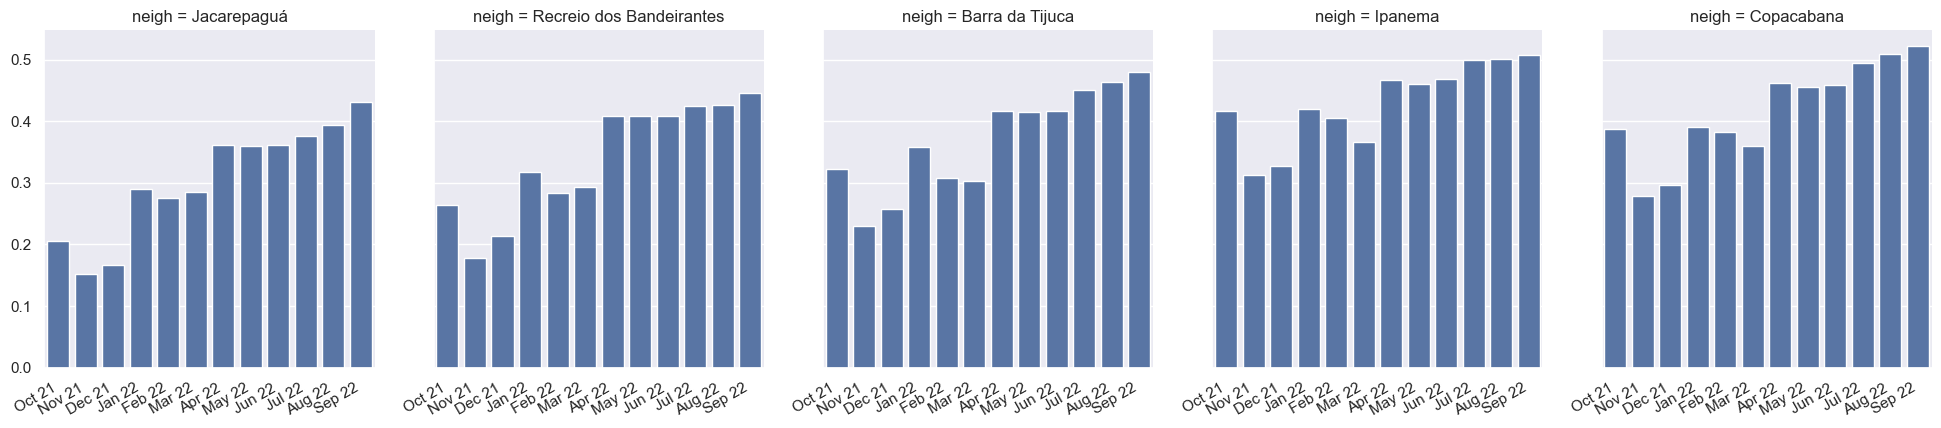

<font face="Calibri"><font size= 5>

Top 5 neighborhoods with accommodation is a greate samples of famous ones.  
The samples in the graphs are Copacabana, Ipanema, Barra da Tijuca, Recreio and Jacarepaguá.  

But, columns it is not a good way to see diferent tendencies for they.  
Let's plot lines

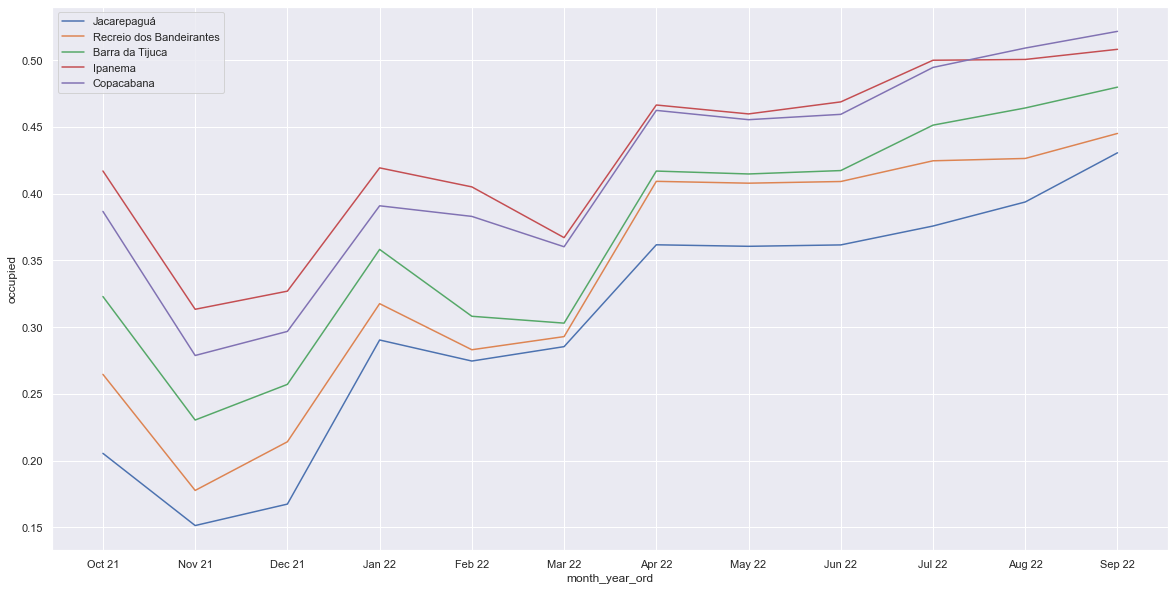

In [31]:
# Plotting in lines
df_aux['month_year_ord'] = pd.Categorical(df_aux.month_year, categories=months, ordered=True)
df_aux.sort_values('month_year_ord')

plt.figure(figsize=(20,10))
sns.lineplot(data=df_aux, x='month_year_ord', y='occupied',hue='neigh', legend='full')
plt.legend()

<font face="Calibri"><font size= 5>

Top 5 neighborhoods with accommodation is a greate samples of famous ones.  
The samples in the graphs are Copacabana, Ipanema, Barra da Tijuca, Recreio and Jacarepaguá.  

But, columns it is not a good way to see diferent tendencies for they.  
Let's plot lines

# Segunda questão 
>
> ## No Brasil, há tanto uma demanda interna pela hospedagem na cidade, quanto externa, de estrangeiros. Como se classificam esses dois tipos de clientes nas avaliações, nas épocas de demanda e nos bairros que eles ficam?

Como avaliam os brasileiros e o estrageiros? 
Há diferença
---  

Como fazer?
1. Pegar a base de review
1. Estudar as avaliações


In [32]:
import numba

import langdetect
import numpy as np
from googletrans import Translator
translator = Translator()

# Using langage detecting to identify the country of reviewer

@numba.jit
def lang_dectection(text):
    '''
    Detection of langage 
    '''
    if isinstance(text, str):
        try:
            return langdetect.detect(text)
        except:
            return np.nan
    else:
        return np.nan

# Detecting the langague 
review_df['lang'] = review_df.comments.map(lambda x: lang_dectection(x) )
review_df['nationality'] = review_df.lang.map({'pt':'brazilian'}).fillna('foreign')

,neigh,exclusivity
6,Recreio dos Bandeirantes,Brazilian
7,Jacarepaguá,Brazilian
10,Leme,Foreign
11,Laranjeiras,Foreign


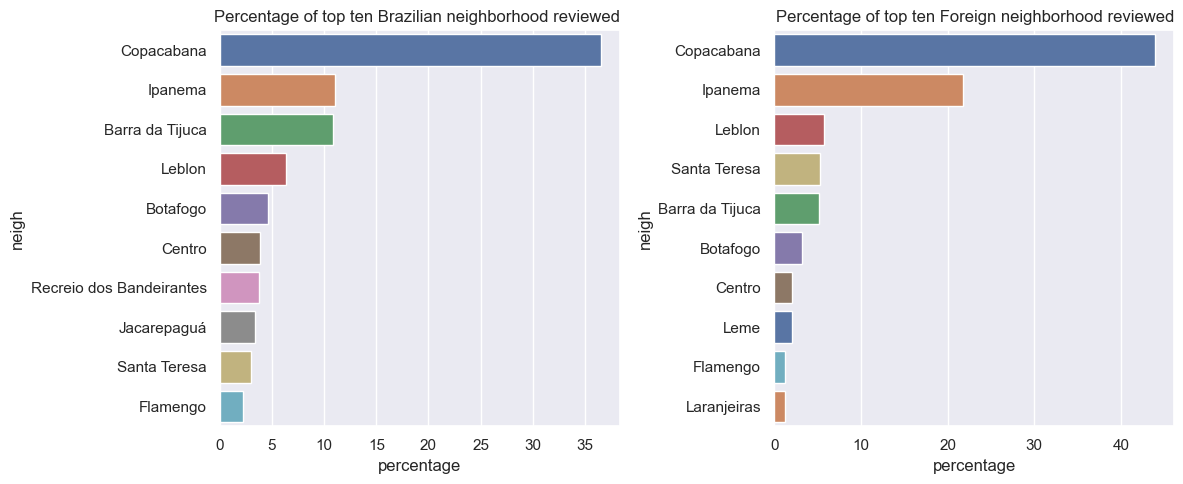

In [260]:
# Mesclar com base de listing e pegar o bairro

# neighborhood_list_df
review_w_neigh = review_df.merge(neighborhood_list_df, left_on='listing_id', right_on='id')

# Grouping dataframe to counting the reviews by neighborhood
nat_neigh = review_w_neigh.groupby(['nationality','neigh']).\
    agg(percentage=('neigh', 'count')).\
        groupby(level=0).apply(lambda x: (x/x.sum())*100).\
            sort_values(['nationality', 'percentage']).\
                rename({'neigh':'per'}, axis=1).\
                    reset_index()
                            
# Plotting
br = nat_neigh[nat_neigh.nationality=='brazilian'].sort_values('percentage',ascending=False)[:10].round(2)
fo = nat_neigh[nat_neigh.nationality=='foreign'].sort_values('percentage',ascending=False)[:10].round(2)

lbls = pd.concat([br.neigh, fo.neigh]).drop_duplicates()
colors = sns.color_palette(n_colors=len(lbls))
colors = dict(zip(lbls,colors))

f, ax = plt.subplots(1,2, dpi=100)

sns.barplot(data=br, x='percentage', y='neigh', palette=colors, ax=ax[0])
sns.barplot(data=fo, x='percentage', y='neigh', palette=colors, ax=ax[1])
ax[0].set_title('Percentage of top ten Brazilian neighborhood reviewed', loc='right')
ax[1].set_title('Percentage of top ten Foreign neighborhood reviewed',loc='right')

f.set_size_inches(12,5)
f.tight_layout()

# Exclusives in both dataframes
br_fo = br.merge(fo, how='outer', left_on='neigh', right_on='neigh', indicator=True)
br_fo[['neigh', '_merge']][(br_fo._merge == 'left_only') | (br_fo._merge == 'right_only')].\
    rename({'_merge':'exclusivity'}, axis=1).\
        apply(lambda x: x.map({'right_only':'Foreign', 'left_only':'Brazilian'}) if x.name == 'exclusivity' else x, axis=0)




# Terceita questão
>
> ## Previsão do preço do imóvel com base nas outras características dele


Quais as variáveis que mais impactam?  
É possível, de início, criar cluster com base nas características numéricas?  
---  

Como fazer?
1. Regressão Linear ou SVR  
1. Estudar os cluster  


In [997]:
# First of all, it is necessary to clean dataframe from empties columns
# It was noted that same columns are just urls. So, it was decided to exclue these too
urls = list_df.columns.str.contains('_url') 
list_df = list_df.loc[:, list_df.columns[~urls]]

# Empties columns
columns_emptiness = pd.Series((list_df.isna().sum()/list_df.shape[0]), name='emptines')
pd.cut(columns_emptiness, bins=np.arange(0,1.1,0.1)).value_counts(normalize=True).round(2) * 100

# About the main column of analysis
list_df.price.isna().sum()

# Select the columns with less than 40% of emptiness
list_df_selc_col = list_df.loc[:, list_df.columns[columns_emptiness < 0.4]]

# There are numeric columns and string columns
list_df_selc_col.dtypes.value_counts()
# It's important analyze the string columns, since some of are useless
list_df_selc_col.describe(include='O').T.sort_values('unique')

# As seen, columns like name and description are useless for regression, because even the number of unique is large and the variable is not cause of price variance
# This time, the columns dtype date are deleted also. It could be used for futher analysis, but in this time it will be exclude
# Some columns need to be transformed in the right type, like host_response_rate and price
''' 
Other columns deleted:
host_has_profile_pic,
has_availability,
bathrooms_text
property_type
'''
remain_string_cols = ['host_has_profile_pic', 'host_identity_verified','host_is_superhost', 
               'instant_bookable', 'host_response_time', 'room_type', 'host_response_rate',
               'host_acceptance_rate', 'neighbourhood_cleansed', 'price']

# Regarding numeric columns, it should have good variable values to contribute to regression
# A lot of columns seems not to cause a great impact on price, like host_listing_count, latitude and others. 
# The evaluation is made
list_df_selc_col.describe().T

# A lot of columns seems not to cause a great impact on price, like host_listing_count, latitude and others. 
# The evaluation is made

remain_num_cols = ['accommodates','bedrooms', 'beds', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

# Uninon of selected columns 
remain_cols = remain_num_cols + remain_string_cols
# Filtering the columns in the dataframe
list_df_selc_col = list_df_selc_col.loc[:, remain_cols]

# Get the string values to numeric values
list_df_selc_col.price = list_df_selc_col.price.str.extract('^\$(.*)')
list_df_selc_col.price = list_df_selc_col.price.str.replace(',','') # Necessaty take off thousand separator to get the numeric value of price
list_df_selc_col.price = pd.to_numeric(list_df_selc_col.price, downcast='float')

list_df_selc_col.host_response_rate = list_df_selc_col.host_response_rate.str.extract('(.*)\%')
list_df_selc_col.host_response_rate = pd.to_numeric(list_df_selc_col.host_response_rate, downcast='float')
list_df_selc_col.host_acceptance_rate = list_df_selc_col.host_acceptance_rate.str.extract('(.*)\%')
list_df_selc_col.host_acceptance_rate = pd.to_numeric(list_df_selc_col.host_acceptance_rate, downcast='float')

# Now, it's time to dummies string variables. But, the neighborhood has 53 possible values. So, it's necessary to create a parallel metric to use neighbohood
# Here, it will be create 4 cluster of neighborhood. This would be a problem for new data, since new neighborhodd would came in. But, for this purporse, this will be used.
# The metric to cluster the neigh was number of accommodations
neigh_clusters = list_df_selc_col.groupby('neighbourhood_cleansed').agg(count=('neighbourhood_cleansed', 'count'))
from sklearn.cluster import k_means
neigh_clusters['neighbourhood_cluster'] = k_means(neigh_clusters.values, n_clusters=4)[1]
neigh_clusters = neigh_clusters.reset_index()[['neighbourhood_cleansed','neighbourhood_cluster' ]]
# Merge back with original dataframe
list_df_selc_col = list_df_selc_col.merge(neigh_clusters, on='neighbourhood_cleansed').drop(columns=['neighbourhood_cleansed'])

# Drop nans
list_df_selc_col = list_df_selc_col.dropna()

# Time to dummie string variables
cols_dummies = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'instant_bookable', 'host_response_time', 'room_type']
list_df_selc_col = pd.get_dummies(list_df_selc_col, columns=cols_dummies, drop_first=False)


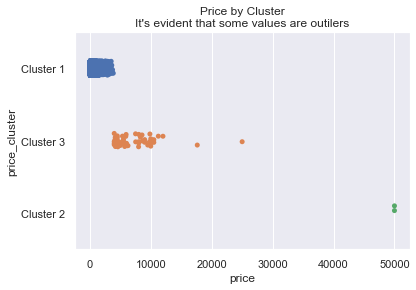

In [999]:
# Outiliers treatment
# It was noted that some values of price are strange
# So, it was decided to analyze the values of price
# This was made by creating cluster of price
from sklearn.cluster import k_means
# Using k_means from sklearn, price was sliced
price_cluster_df = list_df_selc_col[['price']]
price_cluster_df['price_cluster'] = k_means(price_cluster_df.values.reshape(-1, 1), n_clusters=3)[1]
price_cluster_df['price_cluster'] = price_cluster_df.price_cluster.map({0:'Cluster 1',1:'Cluster 2', 2:'Cluster 3'})

# Plotting the price by cluster
ax = sns.stripplot(data=price_cluster_df, x='price', y='price_cluster')
ax.set_title('Price by Cluster\nIt\'s evident that some values are outilers')
plt.show()

# Create a table to observe the variance of values
price_cluster_values = price_cluster_df.groupby('price_cluster')['price'].describe().round(0)

# To make easy regression and avoid working with outilier,
# values only inside cluster 1 was filter in original df
filter_cluster1 = price_cluster_values.loc['Cluster 1', 'max']

# df is the dataframe variable will be used in regression
df = list_df_selc_col.loc[list_df_selc_col.price <= filter_cluster1]

In [971]:
# Other step to execute is filter just variable with
# significant correlation with price
col_w_corr = df.corr()[['price']].\
                    drop('price').\
                    loc[lambda x: abs(x.price) > 0.1].\
                    index.values
# Creating a list of filtered columns from previous
# step and the price column
col_w_corr = np.append(col_w_corr, 'price')

In [1001]:
# Regression

# The dataframe
df = df[col_w_corr]

# Libaries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

# X and y datasets
X = df.drop('price', axis=1)
y = df.price

# Divide the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #, random_state=15)

# Initiate a model
model = LinearRegression(normalize=True)

# Train model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Resulte with r score
r2 = r2_score(y_test,y_pred)
print(f'Performance of model: {"{:.2f}%".format(r2*100)}' )

# Resulte with cross validation
cv_score = np.mean(cross_val_score(model,X_test, y_test, cv = 10))
print(f'With cross validation: {"{:.2f}%".format(cv_score*100)}' ) 

# Showing the coeficent of each variable used
pd.DataFrame({'Variable': X.columns, 'Coef': model.coef_}).sort_values('Coef', ascending=False)

Performance of model: 33.71%
With cross validation: 33.24%


,Variable,Coef
8,room_type_Entire home/apt,160.894617
1,bedrooms,123.852983
9,room_type_Private room,105.124782
0,accommodates,53.514032
7,neighbourhood_cluster,15.946054
3,number_of_reviews,-0.269966
4,number_of_reviews_ltm,-1.313140
6,reviews_per_month,-8.444863
5,number_of_reviews_l30d,-16.901922
2,beds,-17.490691
